<a href="https://colab.research.google.com/github/rahiakela/mlops-research-and-practice/blob/main/automl-in-action/01_end_to_end_ml_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## End-to-end ML pipeline


##Setup

In [23]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

##Assembling the dataset

In [2]:
# Load the California housing dataset
house_dataset = fetch_california_housing()

# Display the oringal data
house_dataset.keys()

# Extract features with their names into the a dataframe format
data = pd.DataFrame(house_dataset.data, columns=house_dataset.feature_names)

# Extract target with their names into a pd.Series object with name MedPrice
target = pd.Series(house_dataset.target, name="MedPrice")

# Visualize the first 5 samples of the data
data.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


### Split the dataset into training and test set


In [3]:
# Split data into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Check the shape of whole dataset and the splited training and test set
print("--Shape of the whole data--\n {}".format(data.shape))
print("\n--Shape of the target vector--\n {}".format(target.shape))
print("\n--Shape of the training data--\n {}".format(X_train.shape))
print("\n--Shape of the testing data--\n {}".format(X_test.shape))

--Shape of the whole data--
 (20640, 8)

--Shape of the target vector--
 (20640,)

--Shape of the training data--
 (16512, 8)

--Shape of the testing data--
 (4128, 8)


In [4]:
(data.shape, target.shape), (X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((20640, 8), (20640,)), ((16512, 8), (16512,)), ((4128, 8), (4128,)))

## Data preprocessing


### Q1: What are the data type of the values in each feature?


In [5]:
data.dtypes

MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object

In [6]:
# Check for feature value type
print("-- Feature type --\n{}".format(data.dtypes))
print("\n-- Target type --\n{}".format(target.dtypes))

-- Feature type --
MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object

-- Target type --
float64


### Q2: How many distinct values each feature has in the dataset?


In [7]:
# Check for unique feature values
print("\n-- # of unique feature values --\n{}".format(data.nunique()))


-- # of unique feature values --
MedInc        12928
HouseAge         52
AveRooms      19392
AveBedrms     14233
Population     3888
AveOccup      18841
Latitude        862
Longitude       844
dtype: int64


### Q3: What are the scale and basic statistics of each feature?


In [8]:
# Viewing the data statistics
pd.options.display.float_format = "{:,.2f}".format
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,"20,640.00","20,640.00","20,640.00","20,640.00","20,640.00","20,640.00","20,640.00","20,640.00"
mean,3.87,28.64,5.43,1.10,"1,425.48",3.07,35.63,-119.57
std,1.90,12.59,2.47,0.47,"1,132.46",10.39,2.14,2.00
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80
50%,3.53,29.00,5.23,1.05,"1,166.00",2.82,34.26,-118.49
75%,4.74,37.00,6.05,1.10,"1,725.00",3.28,37.71,-118.01
max,15.00,52.00,141.91,34.07,"35,682.00","1,243.33",41.95,-114.31


### Q4: Are there missing values contained in the data?


In [9]:
# Copy data to avoid inplace
train_data = X_train.copy()

# Add a column "MedPrice" for the target house price
train_data["MedPrice"] = y_train

# Check if there're missing values
print(
    "\n-- check missing values in training data --\n{}".format(
        train_data.isnull().any()
    )
)
print("\n-- check missing values in test data --\n{}".format(X_test.isnull().any()))


-- check missing values in training data --
MedInc        False
HouseAge      False
AveRooms      False
AveBedrms     False
Population    False
AveOccup      False
Latitude      False
Longitude     False
MedPrice      False
dtype: bool

-- check missing values in test data --
MedInc        False
HouseAge      False
AveRooms      False
AveBedrms     False
Population    False
AveOccup      False
Latitude      False
Longitude     False
dtype: bool


##   Feature engineering


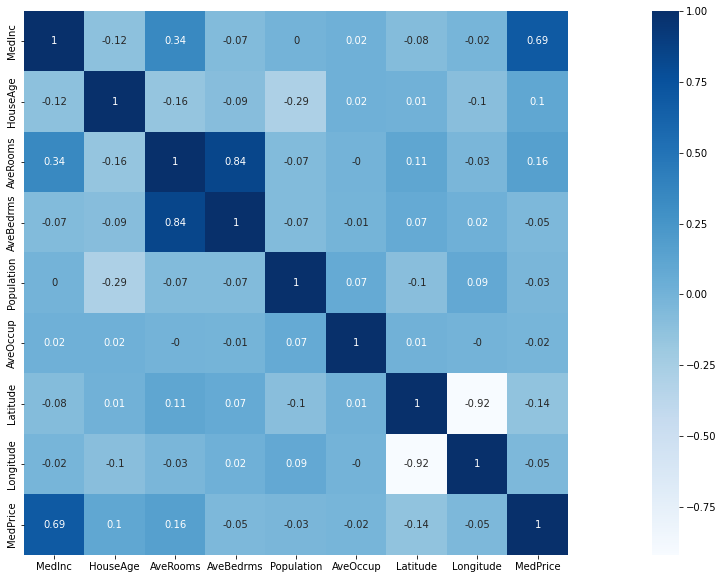

In [10]:
# Plot the correlation across all the features and the target
plt.figure(figsize=(30, 10))

# Calculates the Pearson’s correlation coefficient matrix
correlation_matrix = train_data.corr().round(2)

sns.heatmap(data=correlation_matrix, square=True, annot=True, cmap="Blues")  # fmt='.1f', annot_kws={'size':15},

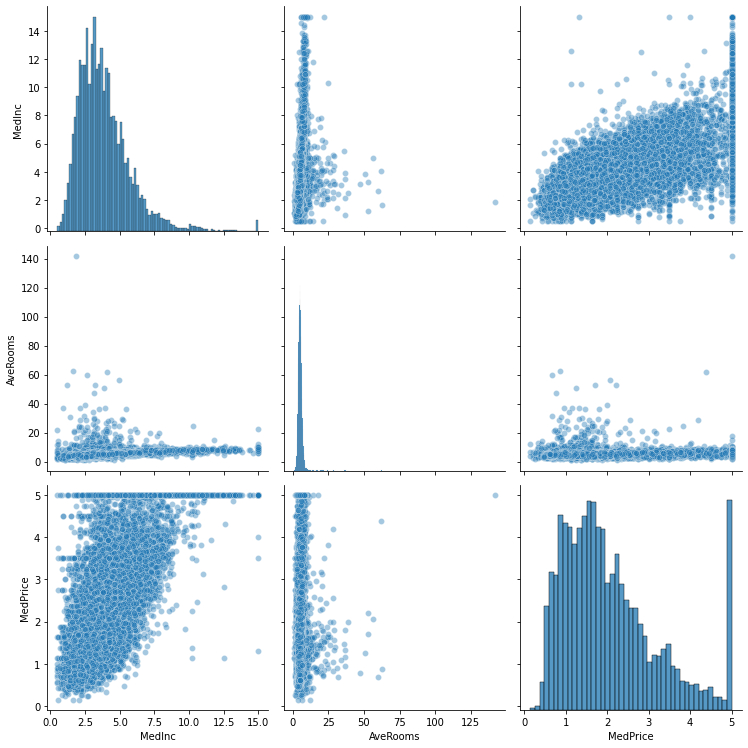

In [11]:
# Select high correlation features & display the pairplot

selected_feature_set = ["MedInc", "AveRooms"]  # 'PTRATIO', , 'Latitude', 'HouseAge'
sub_train_data = train_data[selected_feature_set + ["MedPrice"]]

# Extract the new training features
X_train = sub_train_data.drop(["MedPrice"], axis=1)

# Select same feature sets for test data
X_test = X_test[selected_feature_set]

sns.pairplot(sub_train_data, height=3.5, plot_kws={"alpha": 0.4})
plt.tight_layout()

## ML algorithm selection


### Linear regression


In [12]:
# Training
# Create a Linear regressor
linear_regressor = LinearRegression()

# Train the model using the training sets
linear_regressor.fit(X_train, y_train)

# Display the learned parameters
# Convert the coefficient values to a dataframe
coeffcients = pd.DataFrame(
    linear_regressor.coef_, X_train.columns, columns=["Coefficient"]
)

# Display the intercept value
print("Learned intercept: {:.2f}".format(linear_regressor.intercept_))

print("\n--The learned coefficient value learned by the linear regression model--")
print(coeffcients)


Learned intercept: 0.60

--The learned coefficient value learned by the linear regression model--
          Coefficient
MedInc           0.44
AveRooms        -0.04


In [13]:
# Model prediction on training data
y_pred_train = linear_regressor.predict(X_train)
print("\n--Train MSE--\n{}".format(mean_squared_error(y_train, y_pred_train)))


# Testing
y_pred_test = linear_regressor.predict(X_test)

print("Test MSE: {:.2f}".format(mean_squared_error(y_test, y_pred_test)))



--Train MSE--
0.690985965844761
Test MSE: 0.70


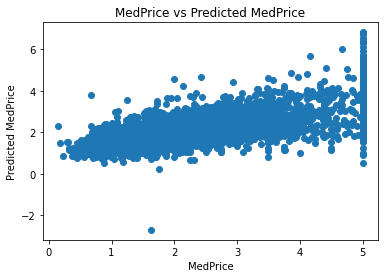

In [14]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_test, y_pred_test)
plt.xlabel("MedPrice")
plt.ylabel("Predicted MedPrice")
plt.title("MedPrice vs Predicted MedPrice")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


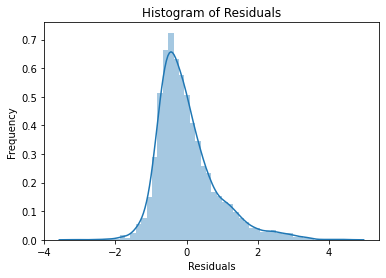

In [15]:
# Checking Normality of errors
sns.distplot(y_test - y_pred_test)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


### Decision tree


In [16]:
# Import library for decision tree
from sklearn.tree import DecisionTreeRegressor

tree_regressor = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_regressor.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=3, random_state=42)

In [17]:
# Model prediction on training & test data
y_pred_train = tree_regressor.predict(X_train)
y_pred_test = tree_regressor.predict(X_test)

print("Train MSE: {:.2f}".format(mean_squared_error(y_train, y_pred_train)))

print("Test MSE: {:.2f}".format(mean_squared_error(y_test, y_pred_test)))


Train MSE: 0.68
Test MSE: 0.71


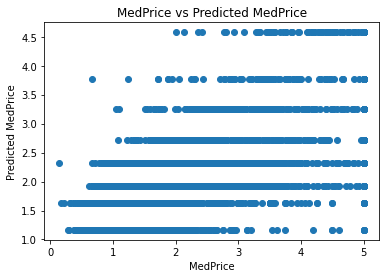

In [18]:
# Plot outputs
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_test, y_pred_test)
plt.xlabel("MedPrice")
plt.ylabel("Predicted MedPrice")
plt.title("MedPrice vs Predicted MedPrice")
plt.show()


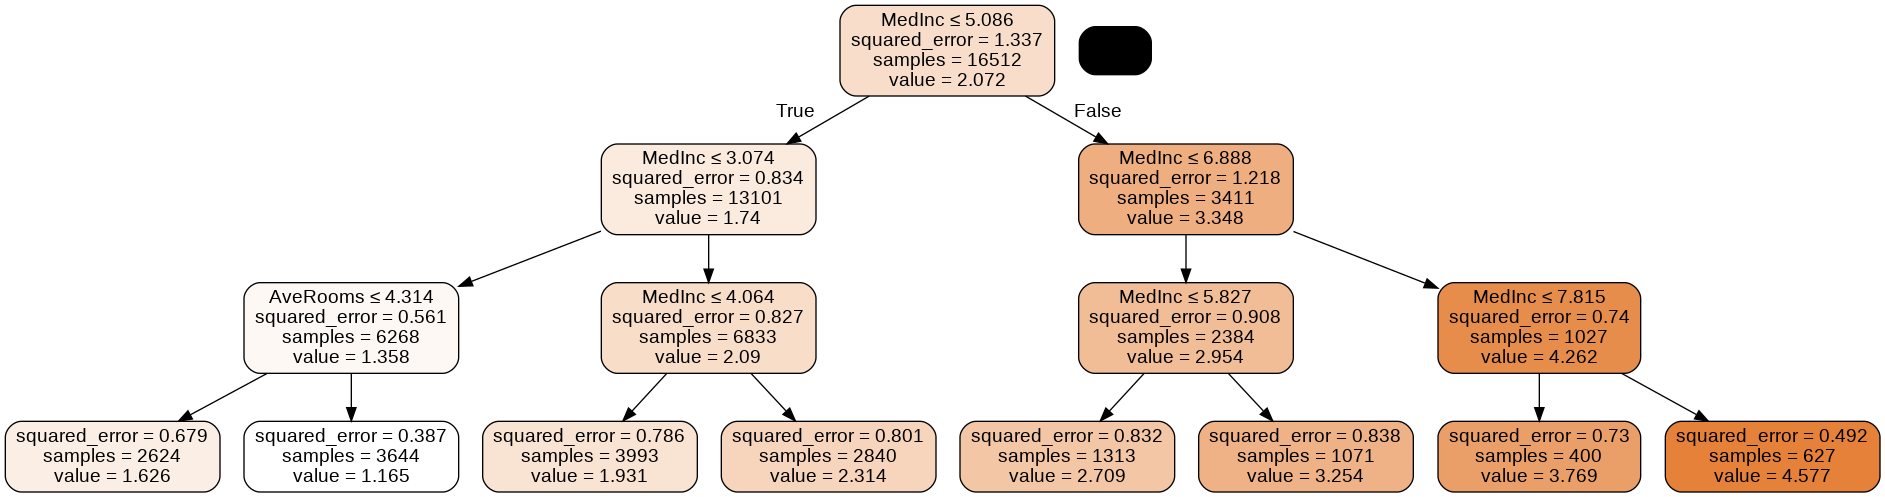

In [19]:
# Visualizing the decision tree
from six import StringIO
import sklearn.tree as tree
import pydotplus

from IPython.display import Image

dot_data = StringIO()
tree.export_graphviz(
    tree_regressor,
    out_file=dot_data,
    class_names=["MedPrice"],  # the target names.
    feature_names=selected_feature_set,  # the feature names.
    filled=True,  # Whether to fill in the boxes with colours.
    rounded=True,  # Whether to round the corners of the boxes.
    special_characters=True,
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Fine-Tuning: tune the tree depth hyperparameter in the tree regressor


In [21]:
kf = KFold(n_splits=5)  # sample indices of datasets for 5-fold cv

cv_sets = []
for train_index, test_index in kf.split(X_train):
    cv_sets.append(
        (
            X_train.iloc[train_index],
            y_train.iloc[train_index],
            X_train.iloc[test_index],
            y_train.iloc[test_index],
        )
    )  # construct 5-fold cv datasets

In [22]:
max_depths = list(range(1, 11))  # candidate max_depth hyperparamters

for max_depth in max_depths:
    cv_results = []
    regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

# loop through all the cv sets and average the validation results
for (x_tr, y_tr, x_te, y_te,) in cv_sets:  
    regressor.fit(x_tr, y_tr)
    cv_results.append(mean_squared_error(regressor.predict(x_te), y_te))
print("Tree depth: {}, Avg. MSE: {}".format(max_depth, np.mean(cv_results)))

Tree depth: 10, Avg. MSE: 0.7023437729999482


In [24]:
# Build up the decision tree regressor
regressor = DecisionTreeRegressor(random_state=42)

# Create a dictionary for the hyperparameter 'max_depth' with a range from 1 to 10
hps = {"max_depth": list(range(1, 11))}

# Transform 'performance_metric' into a scoring function using 'make_scorer'.
# The default scorer function is the greater the better, here MSE is the lower the better,
# so we set ``greater_is_better'' to be False.
scoring_fnc = make_scorer(mean_squared_error, greater_is_better=False)

# Create the grid search cv object (5-fold cross-validation)
grid_search = GridSearchCV(estimator=regressor, param_grid=hps, scoring=scoring_fnc, cv=5)

# Fit the grid search object to the training data to search the optimal model
grid_search = grid_search.fit(X_train, y_train)

0.9167053334390705 {'max_depth': 1}
0.7383634845663015 {'max_depth': 2}
0.68854467373395 {'max_depth': 3}
0.6388802215441052 {'max_depth': 4}
0.6229559075742178 {'max_depth': 5}
0.6181574550660847 {'max_depth': 6}
0.6315191091236836 {'max_depth': 7}
0.6531981343523263 {'max_depth': 8}
0.6778198281721838 {'max_depth': 9}
0.7023437729999482 {'max_depth': 10}


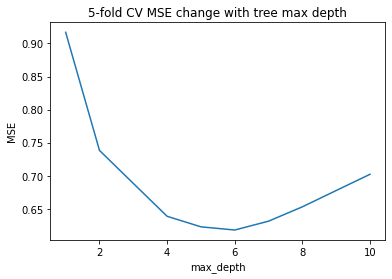

In [25]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

plt.plot(hps["max_depth"], -cvres["mean_test_score"])
plt.title("5-fold CV MSE change with tree max depth")
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.show()

## Retrive the best model


In [26]:
grid_search.best_params_
best_tree_regressor = grid_search.best_estimator_

# Produce the value for 'max_depth'
print("Best hyperparameter is {}.".format(grid_search.best_params_))

# Model prediction on training & test data
y_pred_train = best_tree_regressor.predict(X_train)
y_pred_test = best_tree_regressor.predict(X_test)

print("\n--Train MSE--\n{}".format(mean_squared_error(y_train, y_pred_train)))

print("\n--Test MSE--\n{}\n".format(mean_squared_error(y_test, y_pred_test)))

Best hyperparameter is {'max_depth': 6}.

--Train MSE--
0.5825729954046606

--Test MSE--
0.6422136569733781



## Real test curve V.S. cross-validation curve


Tree depth: 1, Test MSE: 0.9441349708215667
Tree depth: 2, Test MSE: 0.7542635096031615
Tree depth: 3, Test MSE: 0.7063353387614023
Tree depth: 4, Test MSE: 0.6624543803195595
Tree depth: 5, Test MSE: 0.6455716785858321
Tree depth: 6, Test MSE: 0.6422136569733781
Tree depth: 7, Test MSE: 0.6423777285754818
Tree depth: 8, Test MSE: 0.6528185531960586
Tree depth: 9, Test MSE: 0.6748067953031296
Tree depth: 10, Test MSE: 0.7125774158492032


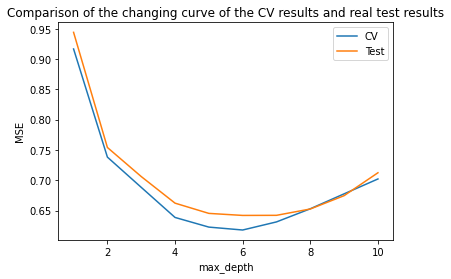

In [27]:
test_results = []
for max_depth in hps["max_depth"]:
    tmp_results = []
    regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    regressor.fit(X_train, y_train)
    test_results.append(mean_squared_error(regressor.predict(X_test), y_test))
    print("Tree depth: {}, Test MSE: {}".format(max_depth, test_results[-1]))

plt.plot(hps["max_depth"], -cvres["mean_test_score"])
plt.plot(hps["max_depth"], test_results)
plt.title("Comparison of the changing curve of the CV results and real test results")
plt.legend(["CV", "Test"])
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.show()